# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. Our model will be trained so that it embeds both images and texts into the same space, and importantly, maps relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function.<br>
<br>
In this note book, we investigate the use of Xception model as the image encoder. The performances will be compared to the base model.

## 1. Preparation
As always, prepare the dataset for the training.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [ ]:
# Split them into training and test sets.
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


In [ ]:
import torch
from torch.utils.data import DataLoader

In [ ]:
# These are the libraries we developed from scratch for this project.
sys.path.append("drive/My Drive/finalproj")
import EncoderHeads, Dataset, utils

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is " + device.type + ".")

The device is cuda.


In [ ]:
# This time, choose Xception for the image encoder instead of InceptionV3.
embed_dim = 256
max_len = 60 # Recommend: 46 for GloVe, 60 for BERT (though the maximum is 146)
image_encoder_model = "Xception"
text_encoder_model = "BERT"
image_head_model = "FC"
text_head_model = "FC"

TrainingDataset = Dataset.DualEncoderDataset(train_images, train_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TestDataset = Dataset.DualEncoderDataset(test_images, test_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TrainingDataset.print_num_params()


Preprocessing image data...


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
100%|██████████| 99/99 [00:32<00:00,  3.08it/s]


Preprocessing text data...


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 985/985 [00:46<00:00, 21.36it/s]



Preprocessing image data...


100%|██████████| 43/43 [00:11<00:00,  3.83it/s]


Preprocessing text data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 422/422 [00:20<00:00, 20.93it/s]


=== Image Encoder ===
  Pretrained Parameters: 20,806,952

=== Text Encoder ===
  Pretrained Parameters: 109,482,240


In [ ]:
epochs = 20
batch_size = 128
train_loss = []
eval_loss = []
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
print(f"=== Image Encoder Head ===")
print(f"  Trainable Parameters: {image_head.num_parameters:,}")
print(f"\n=== Text Encoder Head ===")
print(f"  Trainable Parameters: {text_head.num_parameters:,}")

criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

=== Image Encoder Head ===
  Trainable Parameters: 1,180,416

=== Text Encoder Head ===
  Trainable Parameters: 525,056


## 2. Training and Evaluations

In [ ]:
print("Start Training...")
for epoch in range(epochs):
    trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
    train_loss.append(trainloss)
    evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
    eval_loss.append(evalloss)
    if (epoch + 1) % 2 == 0:
        print(f"Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")
_, sim_mat = utils.eval(testloader, image_head, text_head, criterion, only_loss=False)

Start Training...
Epoch: 2 | Training loss: 0.1271 | Test loss: 0.1238
Epoch: 4 | Training loss: 0.0889 | Test loss: 0.1111
Epoch: 6 | Training loss: 0.0778 | Test loss: 0.1060
Epoch: 8 | Training loss: 0.0720 | Test loss: 0.1046
Epoch: 10 | Training loss: 0.0677 | Test loss: 0.1032
Epoch: 12 | Training loss: 0.0646 | Test loss: 0.1032
Epoch: 14 | Training loss: 0.0621 | Test loss: 0.1014
Epoch: 16 | Training loss: 0.0604 | Test loss: 0.1005
Epoch: 18 | Training loss: 0.0584 | Test loss: 0.1026
Epoch: 20 | Training loss: 0.0571 | Test loss: 0.1012


In [ ]:
xception_loss = {"training": train_loss, "test": eval_loss}
with open(f"drive/My Drive/finalproj/xception_loss.pkl", "wb") as f:
    pickle.dump(xception_loss, f)

In [ ]:
with open(f"drive/My Drive/finalproj/base_model_loss.pkl", "rb") as f:
    base_model_loss = pickle.load(f)

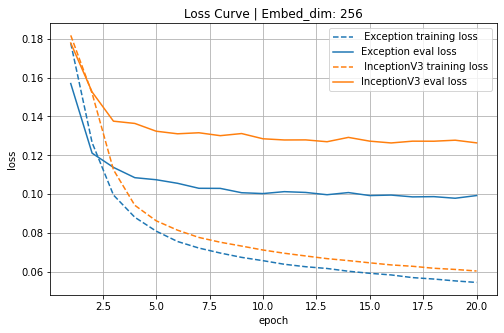

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs + 1), train_loss, label=" Exception training loss", color=plt.cm.tab10(0), linestyle="dashed")
plt.plot(np.arange(1, epochs + 1), eval_loss, label="Exception eval loss", color=plt.cm.tab10(0))
plt.plot(np.arange(1, epochs + 1), base_model_loss["training"], label=" InceptionV3 training loss", color=plt.cm.tab10(1), linestyle="dashed")
plt.plot(np.arange(1, epochs + 1), base_model_loss["test"], label="InceptionV3 eval loss", color=plt.cm.tab10(1))
plt.title(f"Loss Curve | Embed_dim: {embed_dim}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.savefig("xception.png", bbox_inches="tight")
plt.show()

Image Retrieval From Text:
   Median Rank: 27.0 / 1350
   Recall at K: 0.2664
Text Retrieval From Image:
   Median Rank: 278.0 / 13500
   Recall at K: 0.0413


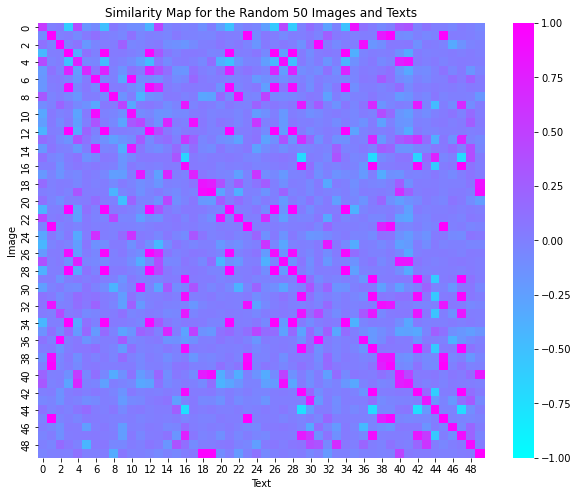

In [ ]:
utils.show_performance(testloader, sim_mat)

## 3. Observation
Xception got a better result of test error $0.0989$ against the base model which had the test error $0.1264$. This is attained with smaller number of pretrained parameters. The Inception V3 has 25,112,264 parameters while Xception has 20,806,952. <br>
In image retrieval task, Xception shows 26 MedR and 0.28 R@K, both better than Inception's 48 MedR and 0.16 R@K. In text retrieval, Xception attains 266 MedR and 0.04 R@K while Inception V3 falls short of 491 MedR and 0.02 R@K.